Necessary imports

In [58]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import numpy as np

if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])


Load, Transform and Split the data

In [65]:
import data_prep

X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1) # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


Create an Ensemble

In [62]:
import NN_model


# number of networks
n = 5
nets_ops = []
for i in range(n):
    net = NN_model.Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[256, 64, 16], output_dim=1, do_rate=0, loss_type='heteroscedastic')  # Create model instance and move to device
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0042, weight_decay=0.0001)  # Create optimizer
    nets_ops.append((net, optimizer))
    
print(nets_ops[0])  # Print the first model to check if it was created correctly

(Custom_NN_Model(
  (hidden_layers): Sequential(
    (0): Linear(in_features=37, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
  )
  (mean_layer): Linear(in_features=16, out_features=1, bias=True)
  (var_layer): Linear(in_features=16, out_features=1, bias=True)
), Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0042
    maximize: False
    weight_decay: 0.0001
))


Method for Training the Ensembles

In [30]:
def train_model(net, optimizer, batch_size=64, n_epochs=1000, patience=20, device = 'cpu'):
    
    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        
    # Early Stopping values
    best_val_loss = np.inf
    epochs_no_improve = 0
    loss_history = []
    val_loss_history = []
    net.to(device)  # Move model to device
    for epoch in range(n_epochs):
        net.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            loss = NN_model.heteroscedastic_loss(net, X_batch, y_batch) # does a forward pass and computes the loss  
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        loss_history.append(loss.item())
            
        # calculate validation loss
        net.eval()                            # Set model to evaluation mode
        with torch.no_grad():

            # Forward pass
            val_loss = NN_model.heteroscedastic_loss(net, X_val, y_val)
                
            val_loss_history.append(val_loss.item())
            
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = net.state_dict()
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {np.mean(batch_losses):.4f}, Val Loss: {val_loss.item():.4f}, Best Val Loss: {best_val_loss:.4f}")
            
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                net.load_state_dict(best_model_state)
                break    
            
    
    outputs_mean, outouts_log_var = net(X_test)
    outputs_mean = outputs_mean.detach().cpu().numpy()
    outputs_log_var = outouts_log_var.detach().cpu().numpy()
    
    return loss_history, val_loss_history, outputs_mean, outputs_log_var

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

outputs_mean = []
outputs_log_var = []
loss_histories = []
val_loss_histories = []
for net, ops in nets_ops:
    loss_history, val_loss_history, output_mean, output_log_var = train_model(net = net, optimizer = ops, device = device)
    outputs_mean.append(output_mean)
    outputs_log_var.append(np.exp(output_log_var))

    loss_histories.append(loss_history)
    val_loss_histories.append(val_loss_history)

outputs_mean = np.array(outputs_mean)
outputs_log_var = np.array(outputs_log_var)

Epoch 1/1000, Train Loss: 43.1499, Val Loss: 4.2570, Best Val Loss: 4.2570
Epoch 2/1000, Train Loss: 2.4981, Val Loss: 2.3291, Best Val Loss: 2.3291
Epoch 3/1000, Train Loss: 2.0664, Val Loss: 2.0180, Best Val Loss: 2.0180
Epoch 4/1000, Train Loss: 1.9565, Val Loss: 1.8783, Best Val Loss: 1.8783
Epoch 9/1000, Train Loss: 1.8966, Val Loss: 1.8758, Best Val Loss: 1.8758
Epoch 10/1000, Train Loss: 1.9288, Val Loss: 1.8565, Best Val Loss: 1.8565
Epoch 11/1000, Train Loss: 1.9155, Val Loss: 1.8088, Best Val Loss: 1.8088
Epoch 18/1000, Train Loss: 1.8663, Val Loss: 1.8058, Best Val Loss: 1.8058
Epoch 22/1000, Train Loss: 1.8148, Val Loss: 1.7576, Best Val Loss: 1.7576
Epoch 26/1000, Train Loss: 1.7969, Val Loss: 1.7311, Best Val Loss: 1.7311
Epoch 28/1000, Train Loss: 1.7904, Val Loss: 1.7001, Best Val Loss: 1.7001
Epoch 32/1000, Train Loss: 1.7195, Val Loss: 1.6988, Best Val Loss: 1.6988
Epoch 35/1000, Train Loss: 1.7382, Val Loss: 1.6956, Best Val Loss: 1.6956
Epoch 36/1000, Train Loss: 1.

Epistemic Variance: 3.198986
Aleatoric Variance: 188.150604
Total Standard Deviation: 3.827715
 y_test std: 7.556901454925537
torch.Size([10403, 1]) (10403, 1)
R² on Test Data: 0.825
Shape of mc_lower_bound: (10403,), mc_upper_bound: (10403,)
Number of true values within the confidence interval: 10106 out of 10403
Coverage: 97.15%


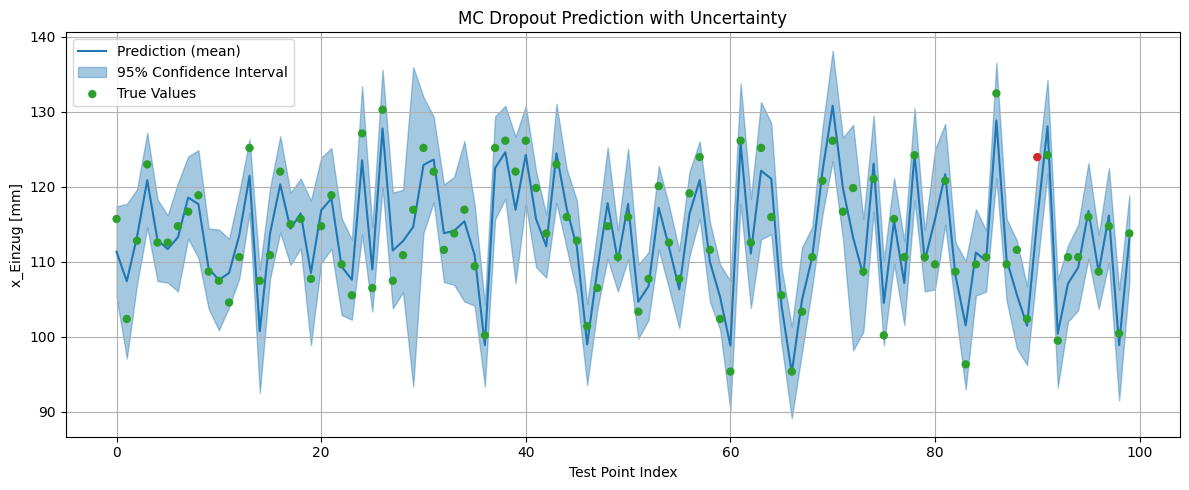

In [66]:
#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
mean_test_pred_heteroscedastic = np.mean(outputs_mean, axis = 0)

# Calculate epistemic
epistemic_var_heteroscedastic = np.var(outputs_mean, axis=0)
print(f"Epistemic Variance: {epistemic_var_heteroscedastic.mean():.6f}")

# Calculate aleatoric variance (heteroscedastic)
aleatoric_var_heteroscedastic = np.mean(outputs_log_var, axis=0)
print(f"Aleatoric Variance: {aleatoric_var_heteroscedastic.mean():.6f}")

# Calculate total standard deviation
total_std_heteroscedastic = np.sqrt(epistemic_var_heteroscedastic + aleatoric_var_heteroscedastic)
print(f"Total Standard Deviation: {total_std_heteroscedastic.mean():.6f}")

print(f' y_test std: {y_test_tensor.std().item()}')
print(y_test_tensor.shape, mean_test_pred_heteroscedastic.shape)
# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu().squeeze(), mean_test_pred_heteroscedastic)
print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = mean_test_pred_heteroscedastic  # Predicted mean for each test point
mc_std = total_std_heteroscedastic   # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = (mc_mean - 2 * mc_std).reshape(-1)  # Ensure it is a 1D array
mc_upper_bound = (mc_mean+ 2 * mc_std).reshape(-1)  # Ensure it is a 1D array

print(f"Shape of mc_lower_bound: {mc_lower_bound.shape}, mc_upper_bound: {mc_upper_bound.shape}")

# calculate the coverage of the confidence interval
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= mc_lower_bound[random_indices]) & (y_test[random_indices] <= mc_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[random_indices], mc_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()